# Climate Analysis (SQLAlchemy) Homework¶

In [63]:
# Import Libraries

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [64]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

from scipy import stats as st
import datetime as dt

In [65]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
inspector = inspect(engine)

In [66]:
# REFLECT AN EXISTING DATABASE INTO A NEW MODEL
Base = automap_base()

# REFLECT THE TABLES
Base.prepare(engine, reflect=True)

In [67]:
# VIEW THE CLASSES FOUND BY AUTOMAP
engine.table_names()

['measurement', 'station']

In [68]:
# SAVE REFERENCES TO EACH TABLE
Measurement = Base.classes.measurement
Station = Base.classes.station

In [69]:
# CREATE OUR SESSION (LINK) FROM PYTHON TO THE DB
session = Session(engine)

In [70]:
# LIST THE CONTENTS OF MEASUREMENT (Get Measurment columns)
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [151]:
# LIST THE CONTENTS OF STATION (Get Station columns)
station_columns = inspector.get_columns('Station')
for columns in station_columns:
    print(columns["name"], columns["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Precipitation Analysis¶
• Design a query to retrieve the last 12 months of precipitation data.
• Select only the date and prcp values.                                                                                        • Load the query results into a Pandas DataFrame and set the index to the date column.                                         • Sort the DataFrame values by date. 
• Plot the results using the DataFrame plot method. 
• Use Pandas to print the summary statistics for the precipitation data.

In [114]:
# 1). Finding the last date in the data - - select only date/prcp values
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

end_date = dt.datetime.strptime(session.query(Measurement.date)[-1:][0][0],'%Y-%m-%d')
end_date = dt.date((end_date).year, (end_date).month, (end_date).day)
start_date = dt.date((end_date).year-1, (end_date).month, (end_date).day)
print(f"The most recent entry into this database was: {end_date}.")
print(f"The last existing date in the Measurement data was: {last_date}")

# 2). Finding the last 12 months FROM last date in data (last 12 mo - 365d) 
last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"A year before the most recent entry was: {start_date}.")
print(f"12 months from last existing date: {last_12_months}")

# 3). Perform a query to retrieve the data and precipitation scores for 'last12mo'
last_year_precipitation = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date >= last_12_months).order_by(Measurement.date).all()
    # last_year_precipitation

# 4). Save the query results as a Pandas DataFrame and set the index to the date column
prcp_1617_df = pd.DataFrame(last_year_precipitation, columns=['Date', 'Precipitation'])

prcp_1617_df.sort_values(by=['Date'])
prcp_1617_df

# 5). Plot the results using the dataframe Plot' Method"

The last existing date in the Measurement data was: ('2017-08-23',)
The most recent entry into this database was: 2017-08-23.
A year before the most recent entry was: 2016-08-23.
12 months from last existing date: 2016-08-23


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


In [74]:
#3) PERFORM A QUERY TO RETRIEVE THE DATA AND PRECIPITATION SCORES
sel = [Measurement.date, func.avg(Measurement.prcp)]
query = session.query(*sel).\
    filter(func.strftime(Measurement.date) >= start_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

In [75]:
#4) SAVE THE QUERY RESULTS AS A PANDAS DATAFRAME AND SET THE INDEX TO THE DATE COLUMN.
# SORT THE DATAFRAME BY DATE
df = pd.DataFrame(query, columns=['Date','Precipitation']).set_index('Date').sort_values(by=['Date'])

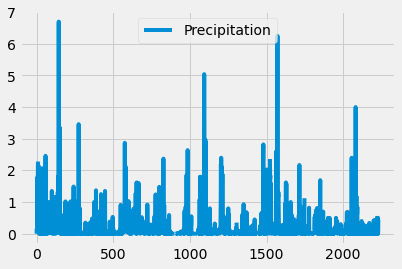

In [103]:
# 5). PLOT THE RESULTS USING THE DATAFRAME USING DATAFRAME 'PLOT' METHOD.

plt.title = ("Precipitation from 2016-08-23 to 2017-08-23")
plt.xlabel = ("Date")
plt.ylabel = ("Precipitation")
plt.legend = ("Precipitation")
prcp_1617_df.plot()
plt.savefig('Images/Precipitation_Plot.png')

In [78]:
# 6) USE PANDAS TO CALCULATE THE SUMMARY STATISTICS FOR THE PRECIPITATION DATA
df.describe()

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Station Analysis
• Design a query to calculate the total number of stations. • Design a query to find the most active stations.                 • List the stations and observation counts in descending order.                                                                • Which station has the highest number of observations?                                                                          • Design a query to retrieve the last 12 months of temperature observation data (tobs).                                          • Filter by the station with the highest number of observations.                                                               • Plot the results as a histogram with bins=12.

In [79]:
# DESIGN A QUERY TO SHOW HOW MANY STATIONS ARE AVAILABLE IN THIS DATASET
query = session.query(Station.station).distinct('station')
print(f"There are a total of {query.count()} stations in this dataset.")

There are a total of 9 stations in this dataset.


In [80]:
# WHAT IS THE MOST ACTIVE STATION?
# LIST THE STATIONS AND THE TEMPERATURE OBSERVATIONS IN DESCENDING ORDER.
sel = [Measurement.station, func.count(Measurement.tobs)]
query = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc())
query_df = pd.DataFrame(query, columns=['station_id','obs_count']).set_index('station_id')
max_station = query_df.index[0]
query_df

,obs_count
station_id,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [150]:
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    limit(1).scalar()

most_active_station

'USC00519281'

In [81]:
# USING THE STATION ID FROM THE PREVIOUS QUERY, CALCULATE THE LOWEST TEMPERATURE RECORDED,
# HIGHEST TEMPERATURE RECORDED, AND AVERAGE TEMPERATURE OF THE MOST ACTIVE STATION.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
query = session.query(*sel).\
    filter(Measurement.station == max_station).all()
query_df = pd.DataFrame(query, columns=['tmin','tavg','tmax'])
query_df

,tmin,tavg,tmax
0,54.0,85.0,71.663781


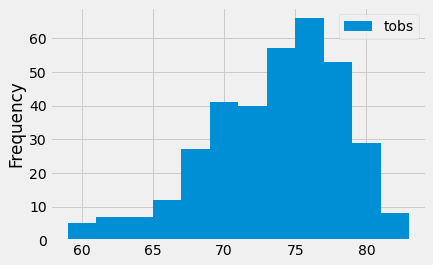

<Figure size 432x288 with 0 Axes>

In [144]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with `bins=12`.

measurement_tobs = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date>= last_12_months).statement

tobs_df = pd.read_sql(measurement_tobs, conn)
tobs_df.plot(kind='hist', bins=12)

plt.show()

plt.savefig('Images/Histogram.png')

# Bonus: Other Recommended Analyses

In [126]:
trip_start_previous_year = '2016-05-21'
trip_end_previous_year = '2016-05-26'

trip_start = '2017-05-01'
trip_end = '2017-05-26'

# Temperature Analysis I

In [127]:
#•	.Does Hawaii demonstrate a meaningful difference between the temperature in June vs.December? (You may either use SQLAlchemy or pandas's read_csv() to perform this portion).
#•	For June and December, identify the average temperature in June at all stations across all available years in the dataset. 
#•	Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [128]:
# SELECT AVERAGE TEMPERATURES FOR ALL STATIONS IN JUNE.
sel = [Measurement.station, func.avg(Measurement.tobs)]
june_query = session.query(*sel).\
    filter(Measurement.date.like('%-06-%')).\
    group_by(Measurement.station)
june_df = pd.DataFrame(june_query, columns=['station_id','avg_temp']).set_index('station_id')

In [129]:
# SELECT AVERAGE TEMPERATURES FOR ALL STATIONS IN DECEMBER.
sel = [Measurement.station, func.avg(Measurement.tobs)]
december_query = session.query(*sel).\
    filter(Measurement.date.like('%-12-%')).\
    group_by(Measurement.station)
december_df = pd.DataFrame(december_query, columns=['station_id','avg_temp']).set_index('station_id')

In [130]:
temperature_df = june_df.merge(december_df, on='station_id', suffixes=['_june','_december'])
temperature_df

,avg_temp_june,avg_temp_december
station_id,,
USC00511918,74.139394,69.684211
USC00513117,74.050847,71.069444
USC00514830,76.005376,73.224719
USC00516128,71.937220,69.291262
USC00517948,76.655405,71.834862
USC00518838,73.394737,72.421053
USC00519281,73.271186,69.903226
USC00519397,77.559322,71.109524
USC00519523,76.668103,72.433333


TypeError: 'str' object is not callable

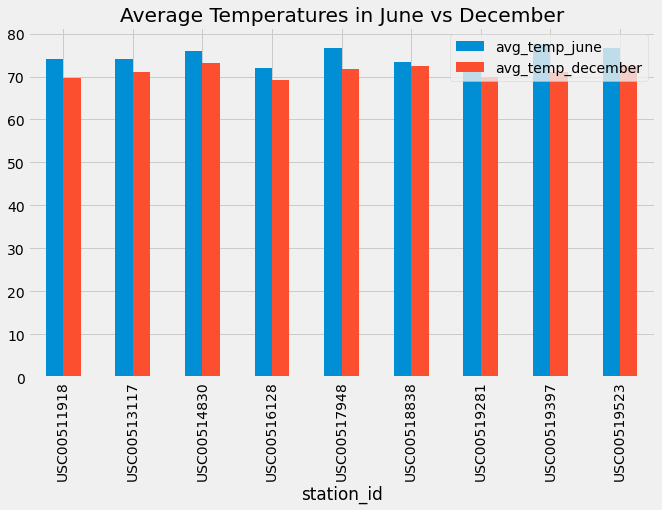

In [131]:
# USE PANDAS PLOTTING WITH MATPLOTLIB TO PLOT THE DATA
bar_plot = temperature_df.plot.bar(figsize=(10,6),title="Average Temperatures in June vs December")
plt.legend(loc='lower center',)
plt.xlabel('Station ID')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.show()

In [121]:
# JUNE STATIONS = DECEMBER STATIONS, SO USE PAIRED T-TEST
t, p = st.ttest_rel(temperature_df.avg_temp_june, temperature_df.avg_temp_december)
print(f"T-Value: {t}")
print(f"P-Value: {p}")
print("These results are statistically significant.")

T-Value: 6.95696617044294
P-Value: 0.00011759380231523222
These results are statistically significant.


# Temperature Analysis II

In [ ]:
# •	The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d. The function will return the minimum, average, and maximum temperatures for that range of dates.
#•	Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").
#•	Plot the min, avg, and max temperature from your previous query as a bar chart.
 #  o	Use the average temperature as the bar height.
 #  o	Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).


In [132]:
# THE FUNCTION CALLED 'calc_temps' WILL ACCEPT START DATE AND END DATE IN THE FORMAT '%Y-%m-%d'
# AND RETURN THE MINIMUM, AVERAGE, AND MAXIMUM TEMPERATURES FOR THAT RANGE OF DATES
def calc_temps(start_date, end_date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-05-21', '2017-05-26'))


[(69.0, 74.94117647058823, 87.0)]


In [133]:
# USE YOUR PREVIOUS FUNCTION 'calc_temps' TO CALCULATE THE TMIN, TAVG, AND TMAX
# FOR YOUR TRIP USING THE PREVIOUS YEAR'S DATA FOR THOSE SAME DATES.
query = calc_temps(trip_start_previous_year,trip_end_previous_year)
tmin = round(query[0][0],2)
tavg = round(query[0][1],2)
tmax = round(query[0][2],2)
_yerr = tmax-tmin
print(f"""Minimum Temperature During Previous Year's Trip Time: {tmin}.
Average Temperature During Previous Year's Trip Time: {tavg}.
Maximum Temperature During Previous Year's Trip Time: {tmax}.""")

Minimum Temperature During Previous Year's Trip Time: 67.0.
Average Temperature During Previous Year's Trip Time: 75.61.
Maximum Temperature During Previous Year's Trip Time: 81.0.


TypeError: 'str' object is not callable

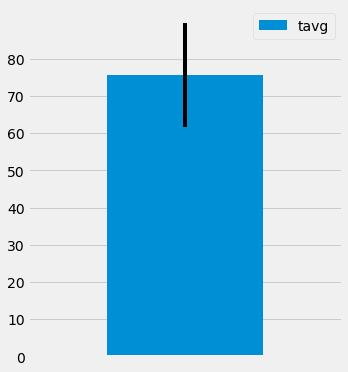

In [134]:
# PLOT THE RESULTS FROM YOUR PREVIOUS QUERY AS A BAR CHART.
# USE "TRIP AVG TEMP" AS YOUR TITLE
# USE THE AVERAGE TEMPERATURE FOR THE Y VALUE
# USE THE PEEK-TO-PEEK (TMAX-TMIN) VALUE AS THE Y ERROR BAR (YERR)
query_df = pd.DataFrame(query, columns=['tmin','tavg','tmax'])

query_df.plot.bar(y='tavg',yerr=_yerr,figsize=(5,6))
plt.xticks(np.arange(1, 1.0))
plt.yticks(np.arange(0, tmax+5, 10))
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.tight_layout()

# Daily Rainfall Average

In [135]:
# CALCULATE THE TOTAL AMOUNT OF RAINFALL PER WEATHER STATION FOR YOUR
# TRIP DATES USING THE PREVIOUS YEAR'S MATCHING DATES.

# SORT THIS IN DESCENDING ORDER BY PRECIPITATION AMOUNT AND LIST
# THE STATION, NAME, LATITUDE, LONGITUDE, AND ELEVATION.

# PERFORM A QUERY TO RETRIEVE THE DATA AND PRECIPITATION SCORES
sel = [Measurement.station, Station.name, 
       func.sum(Measurement.prcp), Station.latitude,
       Station.longitude, Station.elevation]

query = session.query(*sel).\
    filter(Station.station == Measurement.station,
           func.strftime(Measurement.date) >= trip_start_previous_year,
          func.strftime(Measurement.date) <= trip_end_previous_year).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc())
query_df = pd.DataFrame(query, columns=['station_id','station_name','total_rain','station_lat','station_long','station_elevation']).set_index('station_id')
query_df

,station_name,total_rain,station_lat,station_long,station_elevation
station_id,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",2.28,21.33310,-157.80250,152.4
USC00519281,"WAIHEE 837.5, HI US",1.27,21.45167,-157.84889,32.9
USC00513117,"KANEOHE 838.1, HI US",0.88,21.42340,-157.80150,14.6
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.59,21.52130,-157.83740,7.0
USC00519397,"WAIKIKI 717.2, HI US",0.09,21.27160,-157.81680,3.0
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.01,21.33556,-157.71139,19.5
USC00517948,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9


In [136]:
# CREATE A QUERY THAT WILL CALCULATE THE DAILY NORMALS
# (I.E. THE AVERAGES FOR TMIN, TMAX, AND TAVG FOR ALL HISTORIC DATA MATCHING A SPECIFIC MONTH AND DAY)
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [137]:
# CALCULATE THE DAILY NORMALS FOR YOUR TRIP
# PUSH EACH TUPLE OF CALCULATIONS INTO A LIST CALLED NORMALS

# SET THE START AND END DATE OF THE TRIP
start_date = datetime.datetime.strptime(trip_start, '%Y-%m-%d')
end_date = datetime.datetime.strptime(trip_end, '%Y-%m-%d')

# USE THE START AND END DATE TO CREATE A RANGE OF DATES
date_range = [start_date + datetime.timedelta(days=x) for x in range(0, (end_date-start_date).days+1)]

# STRIP OFF THE YEAR AND SAVE A LIST OF %m-%d STRINGS
dates_stripped = [date_range[i].strftime('%m-%d') for i in range(len(date_range))]
dates_stripped

# LOOP THROUGH THE LIST OF %m-%d STRINGS AND CALCULATE THE NORMALS FOR EACH DATE
normals = [daily_normals(i) for i in dates_stripped]

In [138]:
# LOAD THE PREVIOUS QUERY RESULTS INTO A PANDAS DATAFRAME AND ADD THE 'trip_dates' RANGE AS THE 'date' INDEX
tmins = [normals[i][0][0] for i in range(len(normals))]
tavgs = [normals[i][0][1] for i in range(len(normals))]
tmaxs = [normals[i][0][2] for i in range(len(normals))]
tvals = list(zip(dates_stripped, tmins, tavgs, tmaxs))
trip_temperatures = pd.DataFrame(tvals, columns = ['DATES', 'TMINS', 'TAVGS', 'TMAXS']).set_index('DATES')
trip_temperatures

,TMINS,TAVGS,TMAXS
DATES,,,
05-01,65.0,72.759259,79.0
05-02,65.0,73.050847,79.0
05-03,67.0,73.410714,84.0
05-04,65.0,73.596491,78.0
05-05,67.0,73.396552,79.0
05-06,66.0,73.140351,80.0
05-07,64.0,71.788462,79.0
05-08,65.0,72.188679,80.0
05-09,67.0,72.932203,79.0


TypeError: 'str' object is not callable

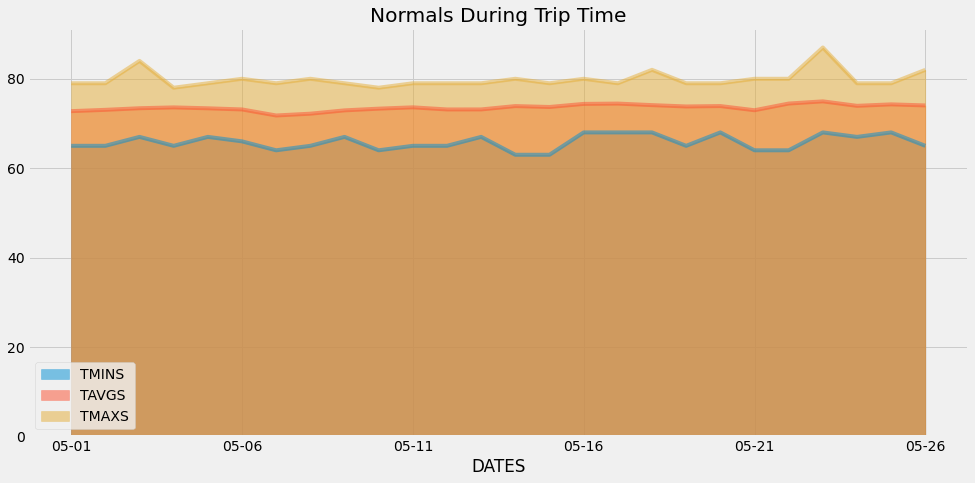

In [139]:
# PLOT THE DAILY NORMALS AS AN AREA PLOT WITH 'stacked=False'
area_plot = trip_temperatures.plot.area(stacked=False, figsize=(15,7), title='Normals During Trip Time')
plt.xlabel('Vacation Dates')
plt.ylabel('Temperature (F)')
plt.legend(loc='lower center')
plt.tight_layout()